[*********************100%***********************]  1 of 1 completed


                  Date       Close       MA_20  Daily Return
0  2024-12-30 00:00:00  251.923019  248.994234     -0.013263
1  2024-12-27 00:00:00  255.309296  248.251551     -0.013242
2  2024-12-26 00:00:00  258.735504  247.219685      0.003176
3  2024-12-24 00:00:00  257.916443  246.023002      0.011478
4  2024-12-23 00:00:00  254.989655  244.757892      0.003065


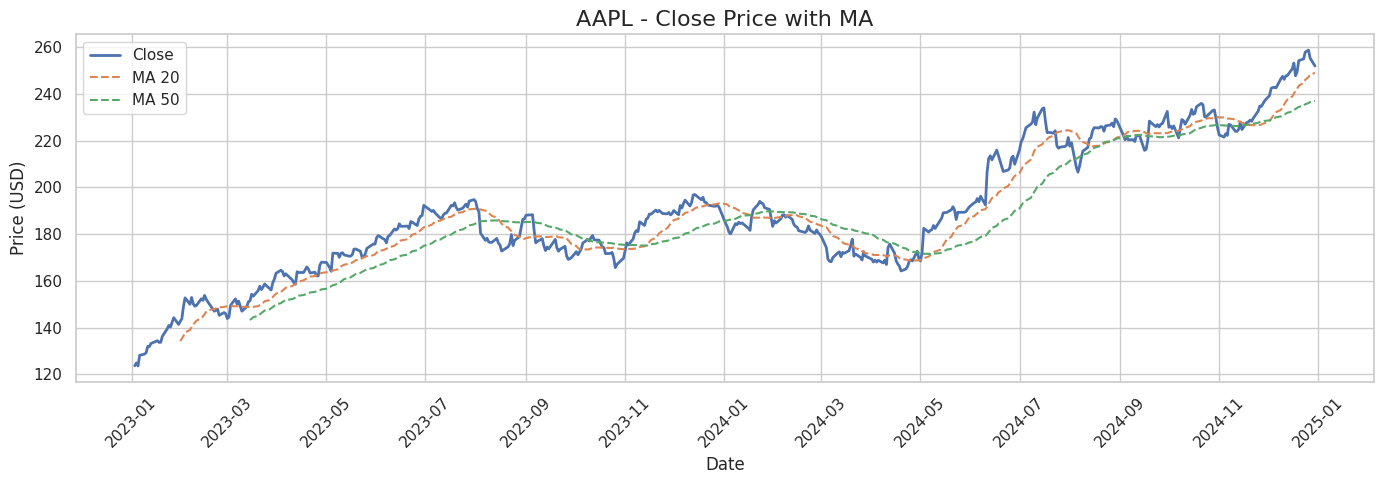

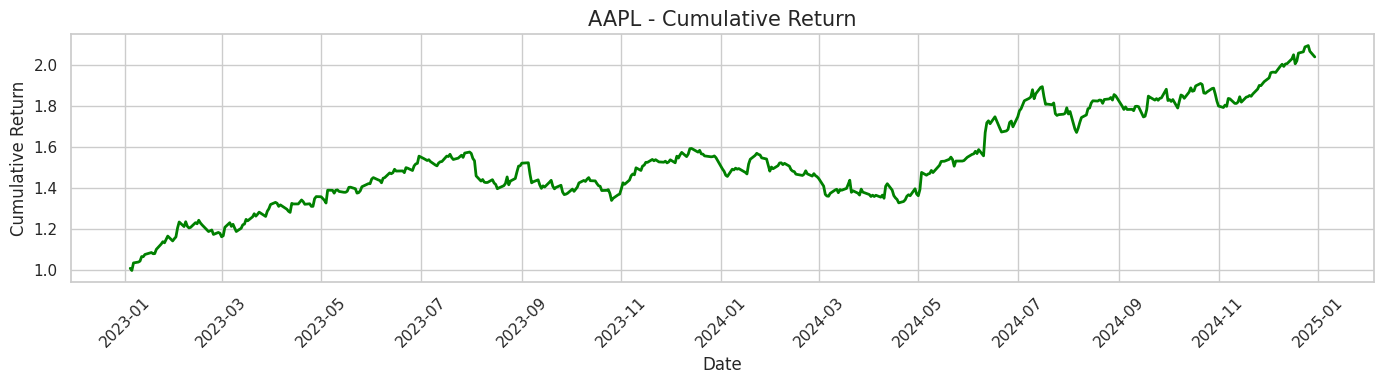

[*********************100%***********************]  1 of 1 completed


                  Date       Close       MA_20  Daily Return
0  2024-12-30 00:00:00  423.979858  439.422899     -0.013240
1  2024-12-27 00:00:00  429.668457  439.354536     -0.017302
2  2024-12-26 00:00:00  437.233276  438.978291     -0.002777
3  2024-12-24 00:00:00  438.450836  438.473305      0.009374
4  2024-12-23 00:00:00  434.379028  437.448361     -0.003092


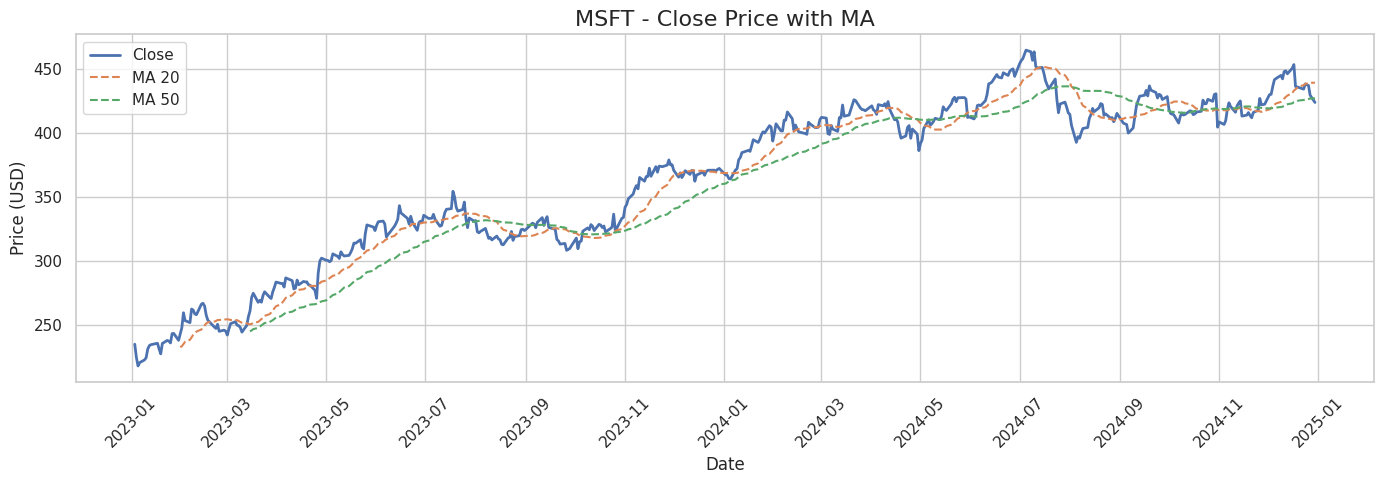

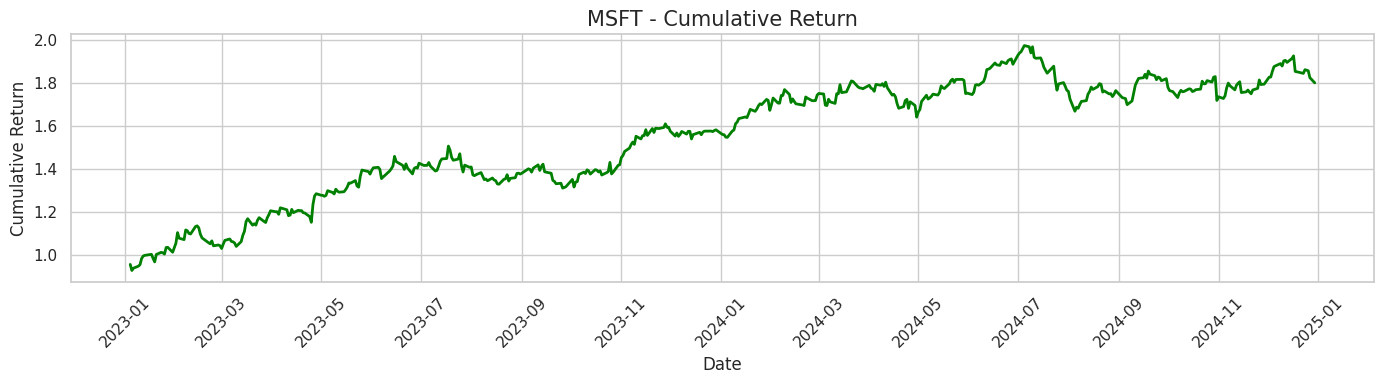

[*********************100%***********************]  1 of 1 completed


                  Date       Close       MA_20  Daily Return
0  2024-12-30 00:00:00  191.020004  186.386354     -0.007885
1  2024-12-27 00:00:00  192.538254  185.263477     -0.014519
2  2024-12-26 00:00:00  195.375000  184.078654     -0.002601
3  2024-12-24 00:00:00  195.884399  182.746508      0.007604
4  2024-12-23 00:00:00  194.406113  181.315559      0.016823


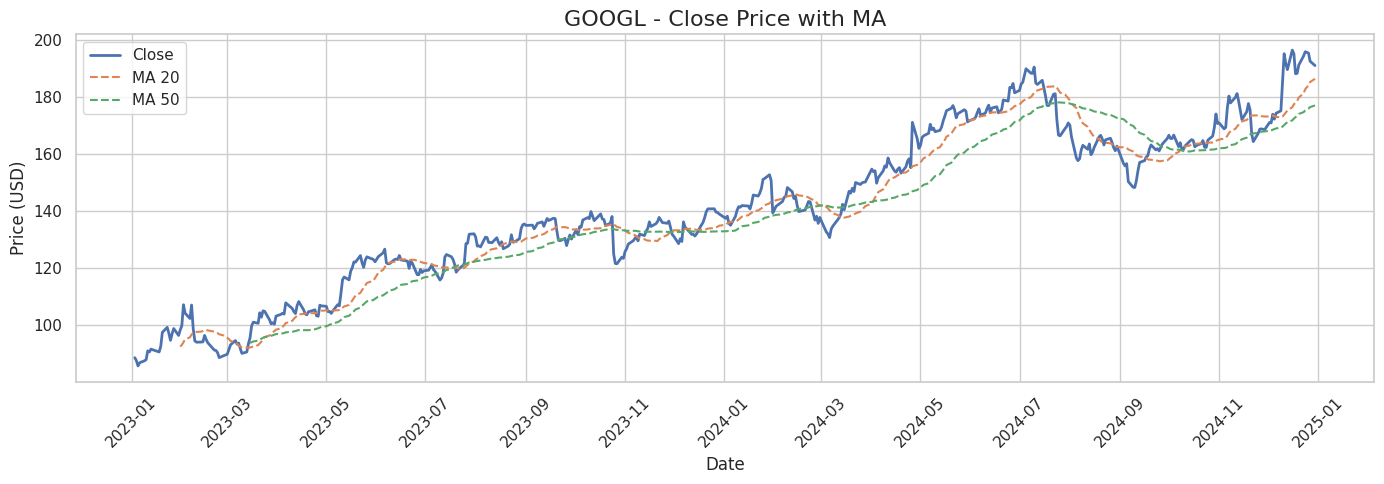

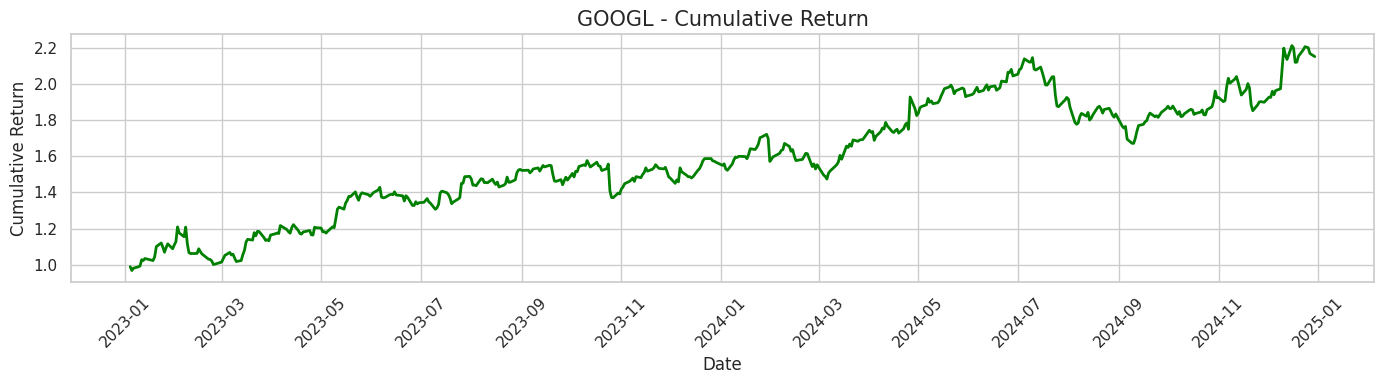

<ipython-input-4-3a8b7072c4ca>:119: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


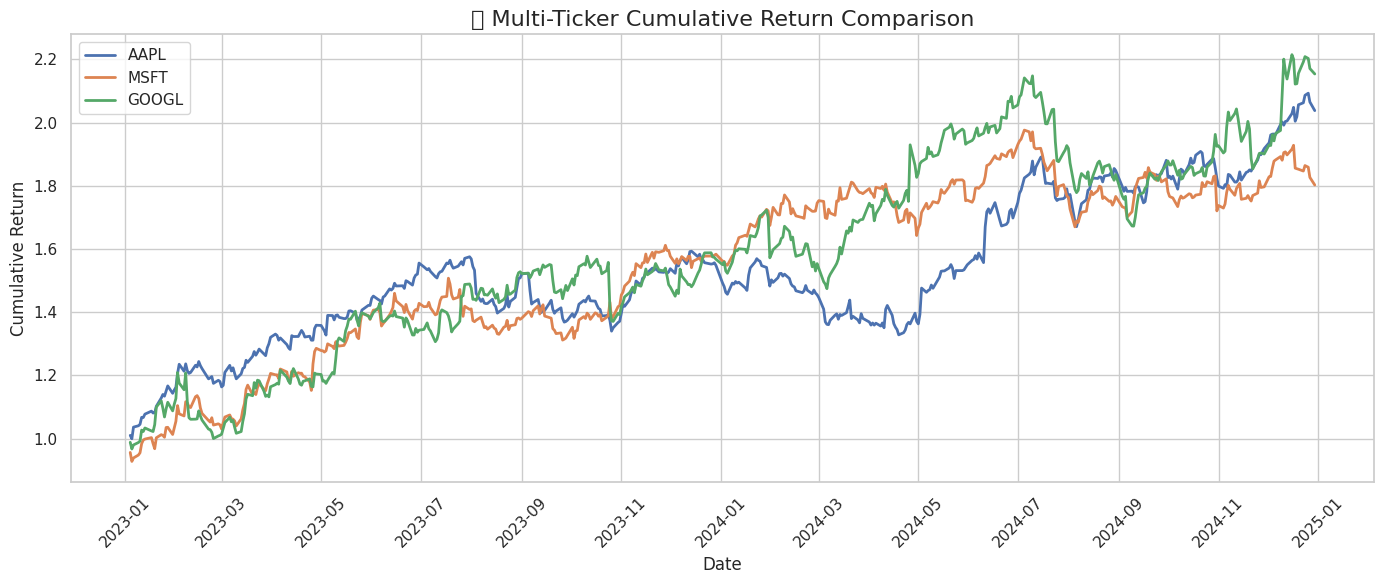

In [4]:
# Stock Market Data Pipeline with Stats and Visuals - SN
import yfinance as yf
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns
import os
import logging

# Configure logging for better debug output
logging.basicConfig(level=logging.INFO, format="%(asctime)s - SN - %(levelname)s - %(message)s")

# --- USER CONFIGURATION ---
TICKERS = ["AAPL", "MSFT", "GOOGL"]   # ✅ Add multiple stock tickers here
START_DATE = "2023-01-01"
END_DATE = "2024-12-31"
DB_PATH = "stock_data.db"

# --- Download stock data from Yahoo Finance ---
def download_stock_data(ticker, start, end):
    logging.info(f"Downloading stock data for {ticker}...")
    df = yf.download(ticker, start=start, end=end)

    # If data has multi-level columns, flatten them
    if isinstance(df.columns, pd.MultiIndex):
        df.columns = [col[0] if isinstance(col, tuple) else col for col in df.columns]

    if df.empty:
        raise ValueError(f"No data downloaded for {ticker}.")

    df.reset_index(inplace=True)  # Make 'Date' a column
    os.makedirs("data", exist_ok=True)
    df.to_csv(f"data/{ticker}_stock_data.csv", index=False)
    logging.info(f"Data saved to data/{ticker}_stock_data.csv")
    return df

# --- Add new features to enhance analysis ---
def engineer_features(df):
    df["MA_20"] = df["Close"].rolling(window=20).mean()
    df["MA_50"] = df["Close"].rolling(window=50).mean()
    df["Volatility_20"] = df["Close"].rolling(window=20).std()
    df["Daily Return"] = df["Close"].pct_change()
    df["Cumulative Return"] = (1 + df["Daily Return"]).cumprod()
    return df

# --- Load the DataFrame into a SQLite database ---
def load_to_sqlite(df, db_path, table_name):
    conn = sqlite3.connect(db_path)
    df.to_sql(table_name, conn, if_exists="replace", index=False)
    conn.commit()
    logging.info(f"{table_name} loaded into SQLite DB.")
    return conn

# --- Show last 5 rows from the database ---
def preview_sql_data(conn, table_name):
    query = f"""
    SELECT "Date", "Close", "MA_20", "Daily Return"
    FROM {table_name}
    ORDER BY "Date" DESC
    LIMIT 5
    """
    try:
        preview = pd.read_sql(query, conn)
        logging.info(f"Preview of {table_name}:")
        print(preview)
    except Exception as e:
        logging.error(f"SQL preview failed for {table_name}: {e}")

# --- Generate informative and clean visualizations for a single ticker ---
import matplotlib.dates as mdates

def plot_visuals(df, ticker):
    sns.set(style="whitegrid")

    # Close Price with Moving Averages
    plt.figure(figsize=(14, 5))
    plt.plot(df["Date"], df["Close"], label="Close", linewidth=2)
    plt.plot(df["Date"], df["MA_20"], label="MA 20", linestyle="--")
    plt.plot(df["Date"], df["MA_50"], label="MA 50", linestyle="--")
    plt.title(f"{ticker} - Close Price with MA", fontsize=16)
    plt.xlabel("Date")
    plt.ylabel("Price (USD)")
    plt.legend()
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=2))  # More x-ticks
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    plt.tight_layout()
    plt.show()

    # Cumulative Return
    plt.figure(figsize=(14, 4))
    plt.plot(df["Date"], df["Cumulative Return"], color="green", linewidth=2)
    plt.title(f"{ticker} - Cumulative Return", fontsize=15)
    plt.xlabel("Date")
    plt.ylabel("Cumulative Return")
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=2))
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    plt.tight_layout()
    plt.show()


# --- Compare cumulative returns across multiple tickers ---
def plot_multi_ticker_comparison(dataframes):
    plt.figure(figsize=(14, 6))
    for ticker, df in dataframes.items():
        plt.plot(df["Date"], df["Cumulative Return"], label=ticker, linewidth=2)

    plt.title("📈 Multi-Ticker Cumulative Return Comparison", fontsize=16)
    plt.xlabel("Date")
    plt.ylabel("Cumulative Return")
    plt.legend()
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=2))
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    plt.tight_layout()
    plt.show()


# --- Main pipeline ---
def main():
    all_data = {}
    conn = sqlite3.connect(DB_PATH)

    for ticker in TICKERS:
        try:
            # 1. Download and process stock data
            df = download_stock_data(ticker, START_DATE, END_DATE)
            df = engineer_features(df)
            all_data[ticker] = df

            # 2. Save to SQLite
            load_to_sqlite(df, DB_PATH, f"{ticker}_stocks")

            # 3. Preview and plot
            preview_sql_data(conn, f"{ticker}_stocks")
            plot_visuals(df, ticker)

        except Exception as e:
            logging.error(f"Error processing {ticker}: {e}")

    # 4. Combined multi-ticker return plot
    if all_data:
        plot_multi_ticker_comparison(all_data)

if __name__ == "__main__":
    main()
